## Data Mining project: Discover and describe areas of interest and events from geo-located data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, kmeans_plusplus, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import re
from preprocessText import process_text,clean_text,remove_adjectives,get_most_frequent_words_by_cluster,remove_non_significant_words
from visualize import generate_word_cloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_path="flickr_data2.csv"
df=pd.read_csv(data_path)
df.head(n=5)

C:\Users\HP\AppData\Local\Temp\ipykernel_17560\3555437615.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(data_path)


id          user        lat      long  \
0  4395181099  30624617@N03  45.754858  4.821710   
1  4394748717  35853470@N00  45.753270  4.862953   
2  4394694699  11817998@N05  45.760655  4.846564   
3  4394803790  11545749@N06  45.784000  4.874072   
4  4394803554  11545749@N06  45.784000  4.874072   

                                                tags  \
0                 chair,lyon,rhône,chaise,rhônealpes   
1                                                NaN   
2                                         365,iphone   
3       nin,nineinchnails,gift,screening,toiou,avott   
4  lyon,nin,nineinchnails,gift,screening,toiou,avott   

                         title   date_taken_minute   date_taken_hour  \
0             Chaises avec vue                11.0                15   
1                          NaN                51.0                17   
2       59/365 - R46 V103 B163                29.0                17   
3  2010-01-29 Toiou Avott Lyon                15.0                20   
4  2010-01-28 Toiou Avott Lyon                10.0                20   

    date_taken_day   date_taken_month   date_taken_year  date_upload_minute  \
0               28                  2              2010                  23   
1               28                  2              2010                  52   
2               28                  2              2010                  33   
3               28                  1              2010                  38   
4               28                  1              2010                  38   

   date_upload_hour   date_upload_day   date_upload_month   date_upload_year  \
0                20              28.0                   2             2010.0   
1                17              28.0                   2             2010.0   
2                17              28.0                   2             2010.0   
3                12              28.0                   2             2010.0   
4                12              28.0                   2             2010.0   

   Unnamed: 16  Unnamed: 17  Unnamed: 18  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

## Discover the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   420240 non-null  int64  
 15   date_upload_year

We notice that the Unnamed columns are all almost empty ,but are filled when data is incoherent . Finally , we decided to just eraze the rows where Unnamed columns are defined , and then we dropped the three columns .

In [5]:
df = df.drop_duplicates(subset=['id'], keep='first')
df = df[df[['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']].isnull().all(axis=1)]


df.drop(columns=['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168050 entries, 0 to 419137
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   168050 non-null  int64  
 1    user                168050 non-null  object 
 2    lat                 168050 non-null  float64
 3    long                168050 non-null  float64
 4    tags                126069 non-null  object 
 5    title               152273 non-null  object 
 6    date_taken_minute   168050 non-null  float64
 7    date_taken_hour     168050 non-null  int64  
 8    date_taken_day      168050 non-null  int64  
 9    date_taken_month    168050 non-null  int64  
 10   date_taken_year     168050 non-null  int64  
 11   date_upload_minute  168050 non-null  object 
 12   date_upload_hour    168050 non-null  object 
 13   date_upload_day     168050 non-null  float64
 14   date_upload_month   168050 non-null  int64  
 15   date_upload_year    1

We also thought about working on data points located in the Lyon region in a defined radius . We define this zone by       

lat_min, lat_max = 45.65, 45.85


lon_min, lon_max = 4.75, 4.95

In [6]:


# Define the bounding box coordinates for the Lyon region
lat_min, lat_max = 45.65, 45.85
lon_min, lon_max = 4.75, 4.95

# Calculate the center of the bounding box
center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

# Create a map centered on the Lyon region
lyon_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define the coordinates for the bounding box
bounding_box_coords = [
    [lat_min, lon_min],  # Bottom-left
    [lat_min, lon_max],  # Bottom-right
    [lat_max, lon_max],  # Top-right
    [lat_max, lon_min],  # Top-left
    [lat_min, lon_min]   # Close the polygon
]

# Add the bounding box to the map
folium.PolyLine(bounding_box_coords, color='blue', weight=2).add_to(lyon_map)

# Display the map
lyon_map.save("lyon_region_map.html")
lyon_map  # This will render the map in a Jupyter Notebook environment if supported



In [7]:


# Filter the DataFrame based on latitude and longitude ranges
filtered_df = df[(df[' lat'] >= lat_min) & (df[' lat'] <= lat_max) &
                 (df[' long'] >= lon_min) & (df[' long'] <= lon_max)]

# Display the filtered DataFrame
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 161654 entries, 0 to 419137
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   161654 non-null  int64  
 1    user                161654 non-null  object 
 2    lat                 161654 non-null  float64
 3    long                161654 non-null  float64
 4    tags                121622 non-null  object 
 5    title               146375 non-null  object 
 6    date_taken_minute   161654 non-null  float64
 7    date_taken_hour     161654 non-null  int64  
 8    date_taken_day      161654 non-null  int64  
 9    date_taken_month    161654 non-null  int64  
 10   date_taken_year     161654 non-null  int64  
 11   date_upload_minute  161654 non-null  object 
 12   date_upload_hour    161654 non-null  object 
 13   date_upload_day     161654 non-null  float64
 14   date_upload_month   161654 non-null  int64  
 15   date_upload_year    1

In [8]:
sampled_df=filtered_df.sample(n=10000,random_state=42)
def lat_long_to_cartesian(lat, long):
    lat_rad = np.radians(lat)
    long_rad = np.radians(long)
    x = np.cos(lat_rad) * np.cos(long_rad)
    y = np.cos(lat_rad) * np.sin(long_rad)
    z = np.sin(lat_rad)
    return np.array([x, y, z])


coords = sampled_df[[' lat', ' long']].to_numpy()
cartesian_coords = np.array([lat_long_to_cartesian(lat, long) for lat, long in coords])
x_squared_norms = np.sum(cartesian_coords ** 2, axis=1)

In [9]:
# # Define the range of cluster numbers to test
# cluster_range = range(20, 40)
# inertia_values = []
# silhouette_scores = []

# # Compute inertia and silhouette scores for each number of clusters
# for k in cluster_range:
#     # Use kmeans_plusplus to initialize centroids
#     init_centers, _ = kmeans_plusplus(cartesian_coords, n_clusters=k, random_state=42, x_squared_norms=x_squared_norms)
#     print("here")
#     # Fit KMeans with initialized centroids
#     kmeans = KMeans(n_clusters=k, init=init_centers, n_init=5, random_state=42,verbose=0)
#     kmeans.fit(cartesian_coords)
    
#     # Store inertia value
#     inertia_values.append(kmeans.inertia_)
    
#     # Compute silhouette score for k > 1
#     if k > 1:
#         silhouette_scores.append(silhouette_score(cartesian_coords, kmeans.labels_))
#     else:
#         silhouette_scores.append(None)  # Silhouette score is undefined for k=1
    
#     print(f'Processed {k} clusters')

# # Plot the elbow curve (inertia values)
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, inertia_values, marker='o', label='Inertia (Elbow Method)')
# plt.title('Elbow Curve for Optimal Clusters', fontsize=16)
# plt.xlabel('Number of Clusters (k)', fontsize=14)
# plt.ylabel('Inertia', fontsize=14)
# plt.xticks(cluster_range)
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the silhouette scores
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range[1:], silhouette_scores[1:], marker='o', label='Silhouette Score')
# plt.title('Silhouette Scores for Optimal Clusters', fontsize=16)
# plt.xlabel('Number of Clusters (k)', fontsize=14)
# plt.ylabel('Silhouette Score', fontsize=14)
# plt.xticks(cluster_range[1:])
# plt.legend()
# plt.grid(True)
# plt.show()


we will go for 29 clusters to have a balance between well defined and compact clusters 

In [10]:
n_clusters=29
init_centers, _ = kmeans_plusplus(cartesian_coords, n_clusters=n_clusters, random_state=42, x_squared_norms=x_squared_norms)
kmeans = KMeans(n_clusters=n_clusters, init=init_centers, n_init=5, random_state=42)
kmeans.fit(cartesian_coords)

c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(init=array([[0.6951384 , 0.05870768, 0.71647471],
       [0.69422802, 0.05862813, 0.71736337],
       [0.69499113, 0.05904519, 0.71658984],
       [0.69576974, 0.05932446, 0.71581078],
       [0.69553652, 0.05865419, 0.71609262],
       [0.6950064 , 0.05924535, 0.7165585 ],
       [0.69542418, 0.06021325, 0.71607232],
       [0.69524442, 0.05907073, 0.71634199],
       [0.69518411, 0.05793049, 0.71649362],
       [0.69600063, 0.05803...
       [0.69546586, 0.05934972, 0.71610394],
       [0.6940695 , 0.05891734, 0.71749305],
       [0.69513102, 0.05886882, 0.71646865],
       [0.69526991, 0.0588384 , 0.71633637],
       [0.69563375, 0.05957803, 0.71592188],
       [0.69563737, 0.05880806, 0.71598203],
       [0.6952084 , 0.05880002, 0.71639922],
       [0.69488769, 0.05923864, 0.71667418],
       [0.69510055, 0.05878008, 0.71650549]]),
       n_clusters=29, n_init=5, random_state=42)

In [11]:

sampled_df['cluster'] = kmeans.fit_predict(cartesian_coords).astype(int) 

map_center = [sampled_df[' lat'].mean(), sampled_df[' long'].mean()]
cluster_map = folium.Map(location=map_center, zoom_start=13)

colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
    'beige', 'darkblue', 'darkgreen', 'cadetblue', 'pink', 'lightblue',
    'lightgreen', 'gray', 'black', 'lightgray', 'brown', 'darkpurple',
    'white', 'lightyellow', 'darkorange', 'teal', 'cyan', 'magenta'
]

for _, row in sampled_df.head(5000).iterrows():
    cluster_color = colors[int(row['cluster']) % len(colors)] 
    folium.CircleMarker(
        location=[row[' lat'], row[' long']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(cluster_map)

cluster_map.save("cluster_map.html")
cluster_map  


c:\Users\HP\Data_Mining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=5.
  super()._check_params_vs_input(X, default_n_init=10)


Now we will try to do the same but using hierarchical clustering this time

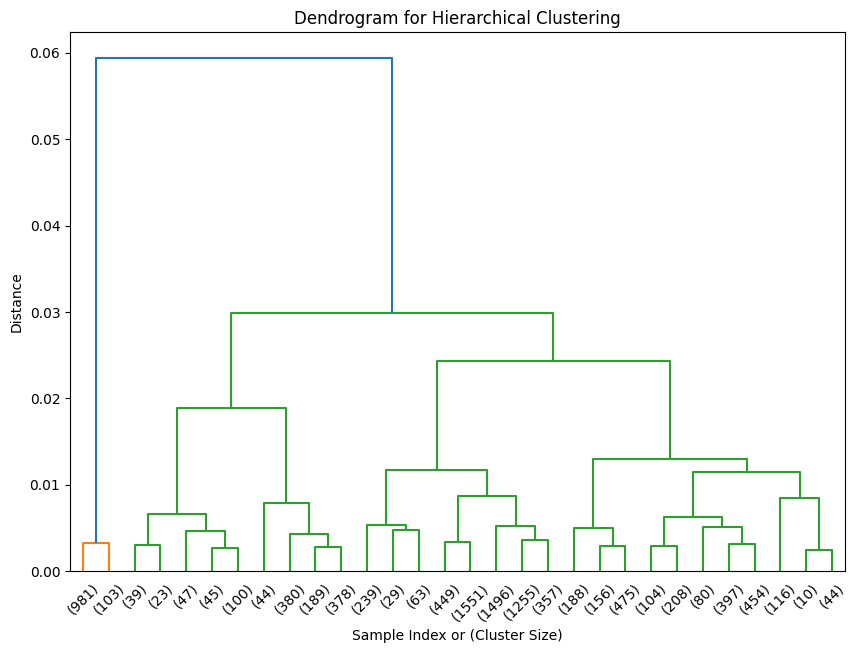

In [12]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')

sampled_df['cluster_hierarchical'] = hierarchical_clustering.fit_predict(cartesian_coords)

# Visualizing the Dendrogram (optional, for analysis)
linkage_matrix = linkage(cartesian_coords, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index or (Cluster Size)")
plt.ylabel("Distance")
plt.show()

A downside of hierarchical clustering is that it is memory excessive , and we are not able to process as much data as we are able to do usng kmeans . We were able to get results though using sampling . 

In [13]:
# Map Visualization for Hierarchical Clustering
map_center = [sampled_df[' lat'].mean(), sampled_df[' long'].mean()]
hierarchical_cluster_map = folium.Map(location=map_center, zoom_start=13)

# Assign colors to clusters (reuse color list or generate dynamically)
for _, row in sampled_df.head(5000).iterrows():
    cluster_color = colors[int(row['cluster_hierarchical']) % len(colors)]
    folium.CircleMarker(
        location=[row[' lat'], row[' long']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_color=cluster_color,
        fill_opacity=0.7
    ).add_to(hierarchical_cluster_map)

# Save the map as an HTML file
hierarchical_cluster_map.save("hierarchical_cluster_map.html")

# Display the map
hierarchical_cluster_map

#### Now We start to do the NLP part

We start by processing the two textual columns  'tags' and 'title'.  We will tokenize the text,remove the stopwords, and finally reduce the words to their root form

In [14]:
sampled_df

id           user        lat      long  \
336844  28402061079  126433826@N05  45.741242  4.816820   
85807    6695379861   42456491@N04  45.759379  4.819955   
347486  42010856942   83294602@N03  45.764910  4.923419   
89       4386491848   32709539@N07  45.764619  4.828330   
259799  26319491282   78191777@N00  45.777258  4.833287   
...             ...            ...        ...       ...   
218119  17090103421   44921934@N00  45.785074  4.853661   
2001     4217324984   62051585@N00  45.767423  4.818736   
176736  13697247344   40936370@N00  45.837410  4.826163   
262983  26568202223  132072072@N08  45.743793  4.855120   
169551  12037607036   89997833@N08  45.749419  4.846655   

                                                     tags  \
336844  streetlevelphotography,streetvivianmaier,stree...   
85807                                                 NaN   
347486       miniworld,maquette,miniature,lyon,mini,world   
89                                      blue,lyon,macaron   
259799  art,collage,outsiderart,mourning,swoon,garage,...   
...                                                   ...   
218119         lyon,sido,iot,internetdesobjets,frenchtech   
2001                                                  NaN   
176736  portrait,sculpture,streetart,france,art,myster...   
262983  skate,skateboarding,skateboard,skatepark,lyon,...   
169551  uploaded:by=flickrmobile,flickriosapp:filter=n...   

                                                    title   date_taken_minute  \
336844                                               Mboz                55.0   
85807                              Premier brin de soleil                35.0   
347486                                           IMG_5234                43.0   
89                                                    NaN                21.0   
259799                                         c'est cela                17.0   
...                                                   ...                 ...   
218119                                      SIdO - l'expo                36.0   
2001                                                  NaN                57.0   
176736  Eloge de la fuite ou la molécule du bonheur......                59.0   
262983                      15052016-Ollie late shovit R_                56.0   
169551                                                NaN                28.0   

         date_taken_hour   date_taken_day   date_taken_month  \
336844                13                5                  2   
85807                 14               14                  1   
347486                15                8                  5   
89                    16                7                  8   
259799                11               13                  6   
...                  ...              ...                ...   
218119                10                7                  4   
2001                  23               26                 12   
176736                16                7                  4   
262983                14               15                  5   
169551                14               12                  1   

         date_taken_year  date_upload_minute  date_upload_hour  \
336844              2018                  18                11   
85807               2012                 2.0                17   
347486              2018                  55                11   
89                  2009                  25                 3   
259799              1985                  48                15   
...                  ...                 ...               ...   
218119              2015                  28                20   
2001                2009                  57                23   
176736              2014                  45                18   
262983              2016                   2                18   
169551              2014                  16                21   

         date_upload_day   date_upload_m

In [31]:
# sampled_df['processed_title'] = sampled_df[' title'].apply(remove_adjectives)
sampled_df['processed_title'] = sampled_df[' title'].apply(process_text)

In [32]:
# sampled_df['processed_title'] = sampled_df[' title'].apply(remove_adjectives)
sampled_df['processed_tags'] = sampled_df[' tags'].apply(process_text)


We will remove numerical data from the texts

In [33]:
sampled_df['processed_tags'] = sampled_df['processed_tags'].apply(clean_text)
sampled_df['processed_tags'] = sampled_df['processed_tags'].apply(remove_non_significant_words)
sampled_df['processed_title'] = sampled_df['processed_title'].apply(clean_text)
sampled_df['processed_title'] = sampled_df['processed_title'].apply(remove_non_significant_words)


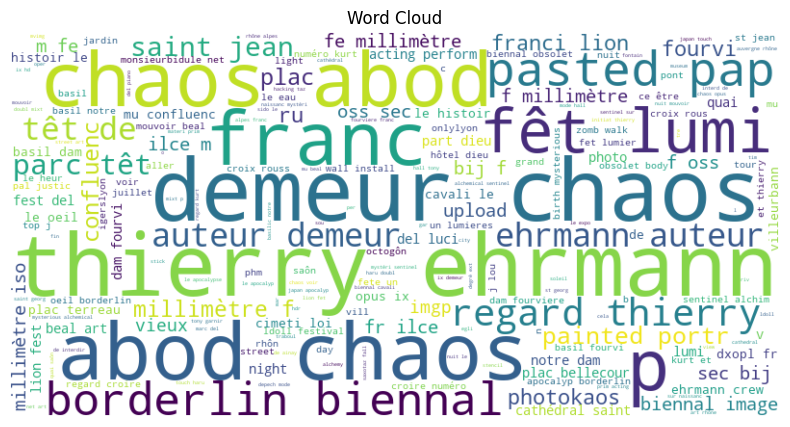

In [34]:
generate_word_cloud(sampled_df, 'processed_title')

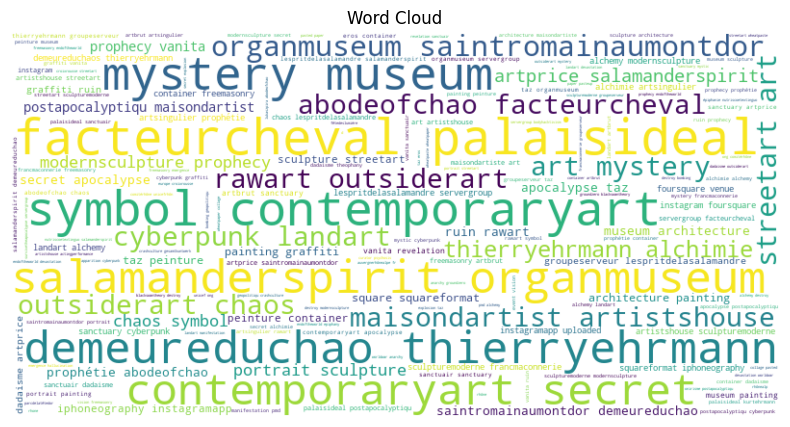

In [35]:
generate_word_cloud(sampled_df, 'processed_tags')

In [36]:
most_frequent_title_words = get_most_frequent_words_by_cluster(sampled_df, 'cluster', 'processed_title', top_n=20)

In [37]:
most_frequent_tags_words = get_most_frequent_words_by_cluster(sampled_df, 'cluster', 'processed_tags', top_n=10)

In [38]:
most_frequent_title_words

{0: [('jean', 106),
  ('saint', 104),
  ('fourvi', 103),
  ('franc', 102),
  ('basil', 77),
  ('dam', 76),
  ('cathédral', 57),
  ('vieux', 54),
  ('millimètre', 52),
  ('fêt', 34),
  ('lumi', 33),
  ('st', 32),
  ('cimeti', 30),
  ('loi', 30),
  ('ru', 28),
  ('fourviere', 24),
  ('fr', 24),
  ('pal', 24),
  ('fe', 23),
  ('plac', 23)],
 1: [('chaos', 522),
  ('ehrmann', 318),
  ('demeur', 278),
  ('thierry', 278),
  ('abod', 236),
  ('regard', 177),
  ('biennal', 132),
  ('borderlin', 132),
  ('auteur', 123),
  ('painted', 80),
  ('portr', 75),
  ('alchim', 64),
  ('photokaos', 61),
  ('image', 55),
  ('perform', 51),
  ('acting', 47),
  ('kurt', 44),
  ('sentinel', 43),
  ('oeil', 42),
  ('apocalyp', 35)],
 2: [('têt', 87),
  ('parc', 86),
  ('fleur', 13),
  ('lumi', 9),
  ('zoo', 9),
  ('fêt', 8),
  ('jardin', 8),
  ('serr', 8),
  ('hiv', 7),
  ('octogôn', 7),
  ('decembr', 6),
  ('grand', 6),
  ('fet', 5),
  ('lumier', 5),
  ('mvimg', 5),
  ('amour', 4),
  ('canard', 4),
  ('lac',